In [11]:
import os, urllib
import pandas as pd
import tensorflow as tf
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.keras.models import model_from_json
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
'''The following is done for the first time, to download the images and save the information to train.csv'''

if not os.path.exists('revision-corpus/data'):
    os.makedirs('revision-corpus/data')
    
data = {'chart': [], 'type': []}

with open('revision-corpus/vis16cat.txt') as handler:
    for index, line in enumerate(handler):
        chartType, chart = line.strip().split("\t")
        fileName = chart.split("/")[-1]
        
        try:
            urllib.request.urlretrieve(chart, "revision-corpus/data/" + fileName)
            data['chart'].append(fileName)
            data['type'].append(chartType)
        except Exception as e:
            print("[{0}][chart] {1}, [type] {2}, [error] {3}".format(index, chart, chartType, e))
                    
traindf = pd.DataFrame(data)

traindf.to_csv('train.csv', index = False)

In [29]:
'''Read from the csv file, if this is not the first time running this code'''

traindf = pd.read_csv('train.csv')

In [30]:
traindf.head()

,chart,type
0,c3_area.jpg,AreaGraph
1,grafico%2Bd%2Barea.jpg,AreaGraph
2,areacolor06.jpg,AreaGraph
3,ZA100902863082%255B1%255D.gif,AreaGraph
4,grafico%2B3b.jpg,AreaGraph


In [31]:
datagen = ImageDataGenerator(rescale=1./255.,
                             rotation_range=10,
                             width_shift_range=0.1, 
                             height_shift_range=0.1)

train_generator = datagen.flow_from_dataframe(
    dataframe = traindf,
    directory = "./revision-corpus/data",
    x_col = "chart",
    y_col = "type",
    subset = "training",
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = "categorical",
    target_size = (224, 224))

Found 593 validated image filenames belonging to 13 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 586 invalid image filename(s) in x_col="chart". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [32]:
vgg_model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))

for layer in vgg_model.layers[:-5]:
    layer.trainable=False
    
input = Input(shape=(224, 224, 3),name = 'image_input')
output_vgg16_conv = vgg_model(input)

x = BatchNormalization()(output_vgg16_conv)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = Dropout(0.2)(x)

x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(13, activation='softmax')(x)

model = Model(inputs=input, outputs=x)

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
batch_normalization_14 (Batc (None, 7, 7, 512)         2048      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 512)         0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 4, 4, 512)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 4096)              3355

In [33]:
model.compile(loss = "categorical_crossentropy",
              optimizer = optimizers.Adadelta(lr = 1.0, rho = 0.95, epsilon = 1e-08, decay = 0.0),
              metrics = ['accuracy'])

In [34]:
STEP_SIZE_TRAIN = train_generator.samples // train_generator.batch_size

history = model.fit(train_generator,
            steps_per_epoch = STEP_SIZE_TRAIN,
            epochs = 50,
            verbose = 1)

Epoch 1/50
 3/18 [====>.........................] - ETA: 4s - loss: 3.3713 - accuracy: 0.1771

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


12/18 [===================>..........] - ETA: 3s - loss: 2.6551 - accuracy: 0.2839

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


18/18 [==============================] - 11s 593ms/step - loss: 2.6077 - accuracy: 0.2865
Epoch 2/50
18/18 [==============================] - 11s 618ms/step - loss: 1.6338 - accuracy: 0.5187
Epoch 3/50
18/18 [==============================] - 11s 631ms/step - loss: 1.1167 - accuracy: 0.6542
Epoch 4/50
18/18 [==============================] - 10s 536ms/step - loss: 1.0039 - accuracy: 0.7041
Epoch 5/50
18/18 [==============================] - 11s 599ms/step - loss: 0.7023 - accuracy: 0.7807
Epoch 6/50
18/18 [==============================] - 11s 617ms/step - loss: 0.7041 - accuracy: 0.7754
Epoch 7/50
18/18 [==============================] - 11s 614ms/step - loss: 0.4915 - accuracy: 0.8324
Epoch 8/50
18/18 [==============================] - 10s 578ms/step - loss: 0.4584 - accuracy: 0.8699
Epoch 9/50
18/18 [==============================] - 11s 624ms/step - loss: 0.3744 - accuracy: 0.8717
Epoch 10/50
18/18 [==============================] - 11s 625ms/step - loss: 0.3445 - accuracy: 0.8948


In [35]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


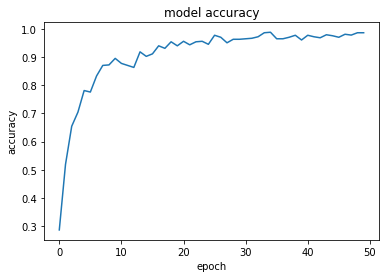

In [38]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

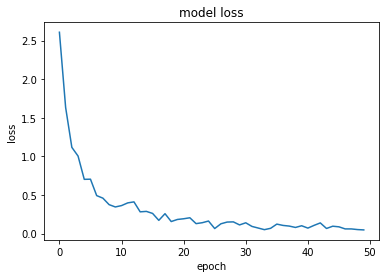

In [39]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [5]:
testdf = pd.read_csv('test.csv')

test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = testdf,
    directory = "./../DataMining/AllData/filtered/images/",
    x_col = "chart",
    y_col = None,
    batch_size = 1,
    seed = 42,
    shuffle = False,
    class_mode = None,
    target_size = (224, 224))

Found 9709 validated image filenames.


In [6]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [14]:
test_generator.reset()
STEP_SIZE_TEST=test_generator.n // test_generator.batch_size

pred = loaded_model.predict(test_generator,
                            steps=STEP_SIZE_TEST,
                            verbose=1)

In [ ]:
predicted_class_indices = np.argmax(pred, axis=1)

In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [ ]:
filenames = test_generator.filenames

results = pd.DataFrame({"chart": filenames, "type": predictions})
results.to_csv("predictions.csv", index = False)